## Visualizing crime statistics in LA

### Goal: 
To understand the crime landscape in LA by answering the following questions.
##### What are most recurring crimes in LA?
##### Is the police response a match for the criminal activity?
##### Does the LA police deparment seems to follow a strategy based on data to mitigate crime?

In [7]:
#We start by importing our dependencies
import pandas as pd
from help_functions import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})

In [2]:
# Loading csv files into dataframes
path = 'los-angeles-crime-arrest-data/'
cri = pd.read_csv(path + 'crime-data.csv', encoding='utf-8')
arr = pd.read_csv(path + 'arrest-data.csv', encoding='utf-8')

In [3]:
# Preparing date variables to be able to compare accross databases
cri = prepare_data(cri)
arr = prepare_data(arr)

In [4]:
print('This analysis takes data from the LA Police department from {}, until {}.'.format(cri.date.min(), cri.date.max()))
print('The final table contains {} cases.'.format(cri.shape[0]))
print('The LA police identifies in its database {} types of crimes.'.format(cri['Crime Code'].value_counts().shape[0]))

This analysis takes data from the LA Police department from 2018-12-25 00:00:00, until 2019-06-22 00:00:00.
The final table contains 103181 cases.
The LA police identifies in its database 130 types of crimes.


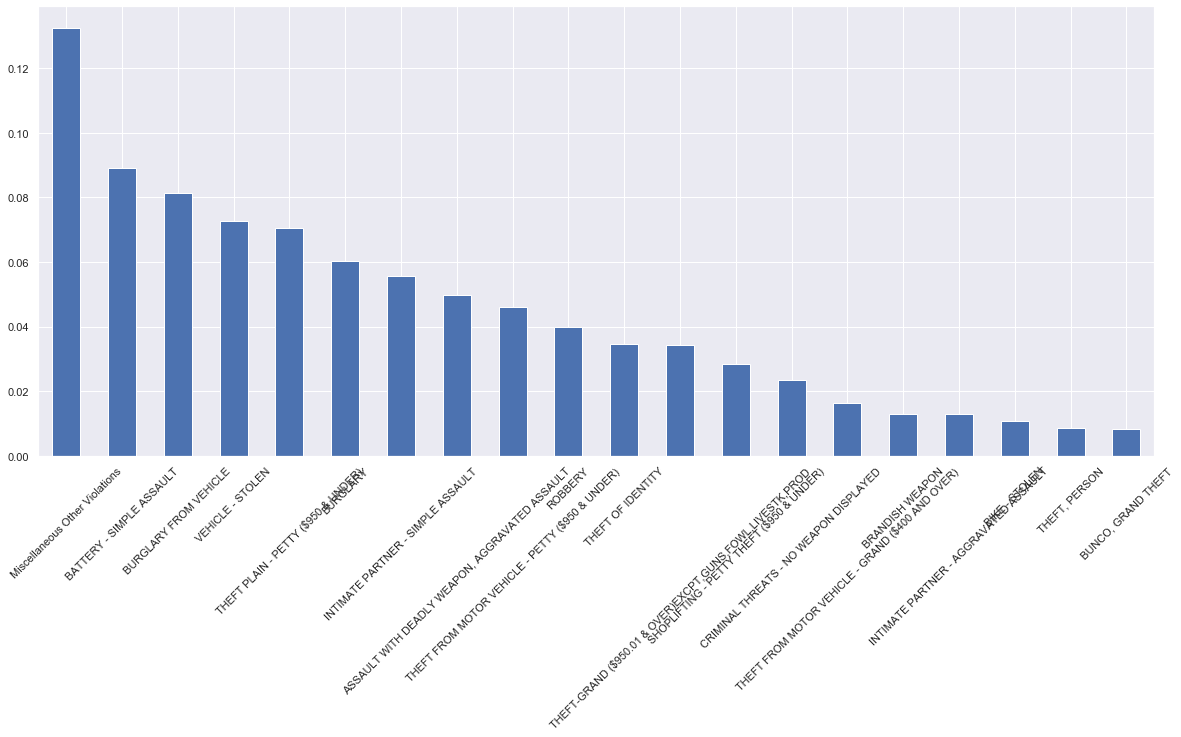

In [8]:
most_frequent_crimes = cri['Crime Code Description'].value_counts().head(20) / cri['Crime Code'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

At first glance, the first hurdle to analyse paterns in crime is the high detail in the typification of crimes: 130 possible offences. As the previous graph shows, some crimes could be grouped together (like different types of burglaries and thefts). Currently, there is only one type of crime that accounts for more than 10% of the total incidents, and even this seems a bit too broad "Miscellaneous Other Violations".

Following an analysis of how the policie typifies crimes, I relabeled the crime description code, based on the variable 'Charge Group Description', from the arrests database. We could benefit in two ways from this: first, we would have broader categories for types of crimes, allowing us to identify the main problems in the city; second, we could have consistency across the crime and arrests database. 

The next graph is the same graph as above, but after relabeling the most recurrent crimes. 

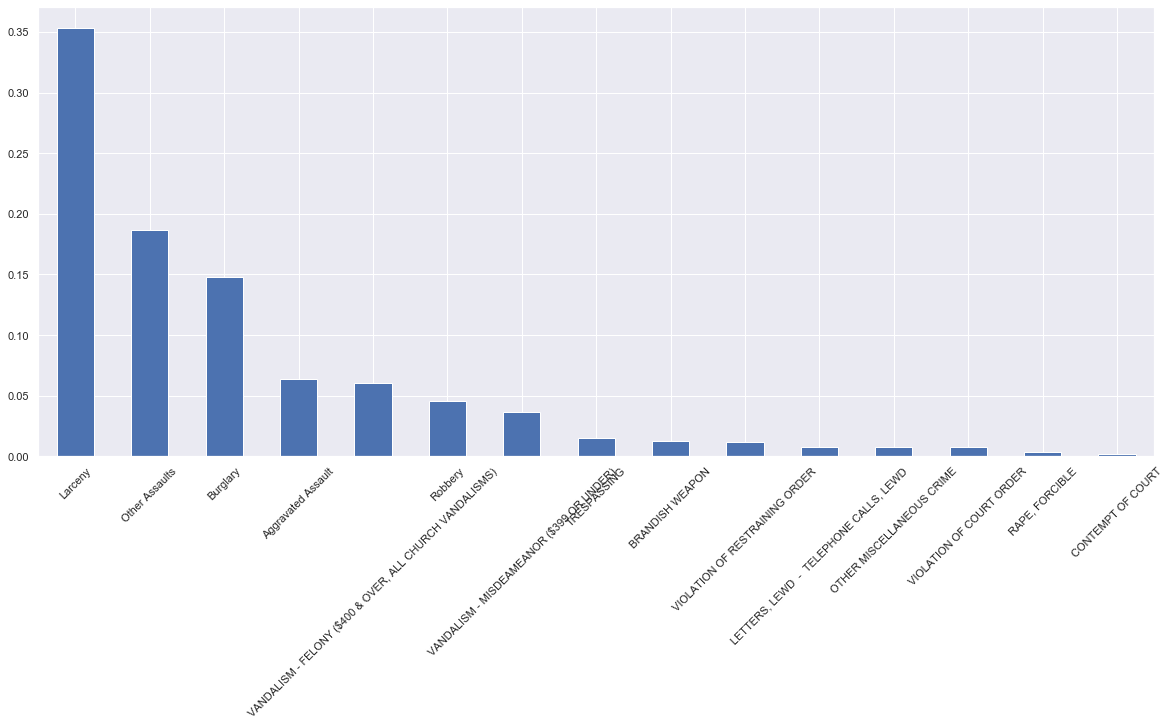

In [9]:
most_frequent_crimes = cri['crime_description_recoded'].value_counts().head(15) / cri['crime_description_recoded'].value_counts().sum()
chart = most_frequent_crimes.plot.bar()
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

As we can see, when we regroup the crime descriptions, it becomes evident that there are six types of crimes that account for more than 80% of the criminal activity. In particular, larceny alone accounts for about a third of all crime. It's noteworthy that most of the thefts are non violent. Larceny implies the theft of property, but not directly from its owner; and burglary implies that somebody entered a building to take something, but again, they are not like robbery, which implies that somebody was taking from someone using force. [references: see here](https://www.criminaldefenselawyer.com/resources/criminal-defense/criminal-offense/differences-between-theft-burglary-robbery)

In [28]:
top_crimes = cri['crime_description_recoded'].value_counts().head(6).index

Let's take a look from another angle: the weekly pattern of criminal activity. Criminal activity, on average, seems to be almost evenly distributed throughout the week.  The day of the week is Sunday, and then it grows gradually, to hit a peak on fridays. Then saturday goes down again. 

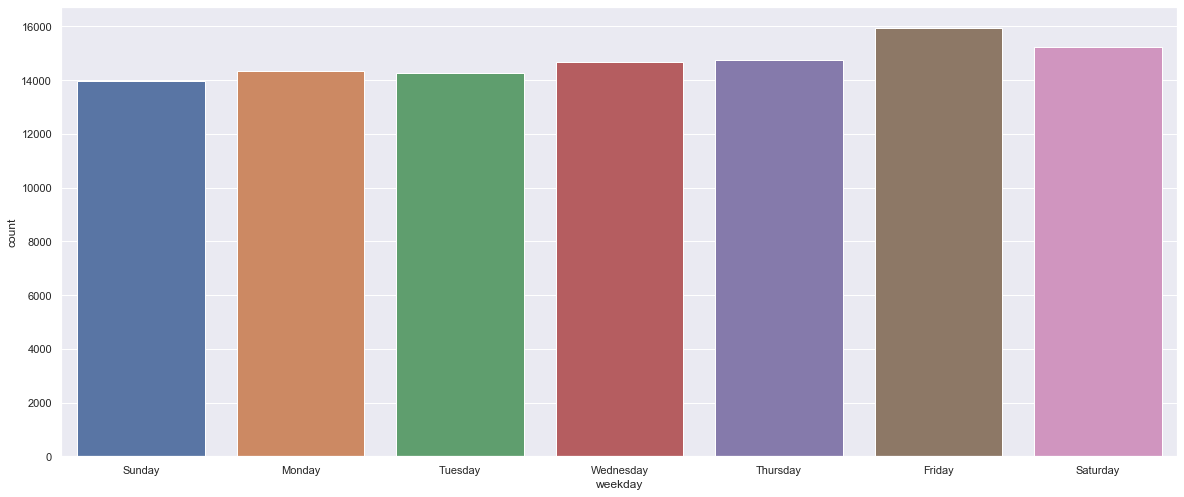

In [29]:
ax = sns.countplot(x="weekday", data=cri, order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

In [30]:
top_crimes

Index(['Larceny', 'Other Assaults', 'Burglary', 'Aggravated Assault',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 'Robbery'],
      dtype='object')

When we limit the analysis by day of the week to the top six crimes, as defined above, there are some interesting findings. Friday is the top day for two of the most prevalent crimes: burglary and larceny. Without doing too much research, one could speculate that this is the day of the week that most people go out for dinner or entertainment, living their homes unattended, and are probably less careful about their belongings. For aggravated and other types of assault, perhaps the most worrysome crime in this bundle because it implies violence, the peak occurs on weekends both saturday and sunday. 

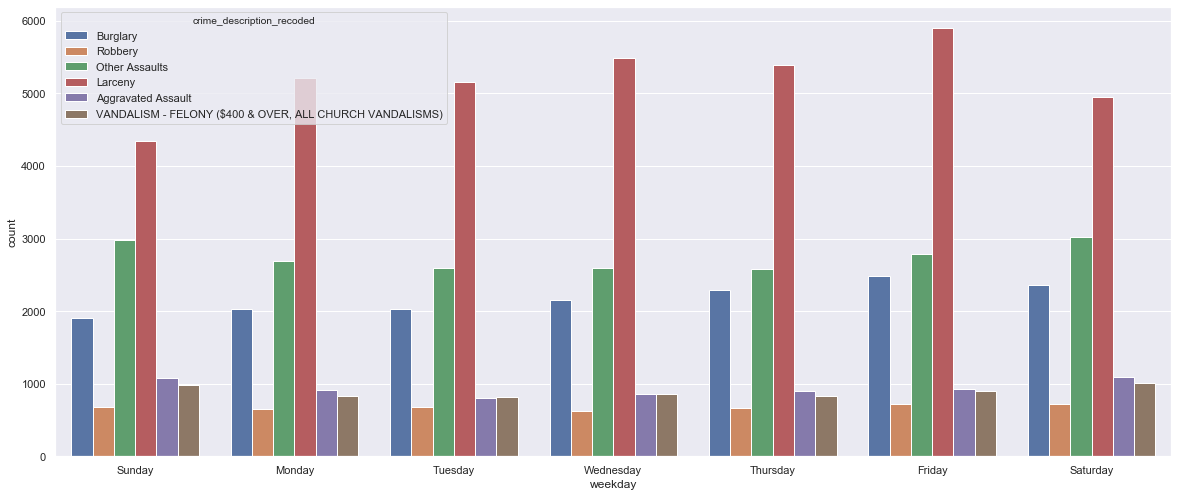

In [31]:
ax = sns.countplot(x="weekday", data=cri[cri['crime_description_recoded'].isin(top_crimes)], hue = 'crime_description_recoded', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

To answer question 1 (**What are most recurring crimes in LA?**): The most reccurent crime in LA is burglary, with more than 36 thousand cases every six months. Along with assaults, and burglaries, they account for moe than 70% of the criminal activity. As we can see, these crimes share in common that they show an even distritution during the weekd days, and an increase toward the weekend. Activities related to stealing property, like burglary and larceny, reak a peak on fridays; assaults, aggravated and other types, occur more often on Saturdays and Sundays. 

In [33]:
cri['crime_description_recoded'].value_counts().head(6)

Larceny                                                    36439
Other Assaults                                             19241
Burglary                                                   15237
Aggravated Assault                                          6545
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     6226
Robbery                                                     4727
Name: crime_description_recoded, dtype: int64

In [34]:
### What are most recurring crimes in LA?
cri['crime_description_recoded'].value_counts().head(20) / cri.shape[0]

Larceny                                                    0.353156
Other Assaults                                             0.186478
Burglary                                                   0.147673
Aggravated Assault                                         0.063432
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    0.060341
Robbery                                                    0.045813
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   0.036334
TRESPASSING                                                0.015274
BRANDISH WEAPON                                            0.013045
VIOLATION OF RESTRAINING ORDER                             0.011950
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD                    0.008034
OTHER MISCELLANEOUS CRIME                                  0.007908
VIOLATION OF COURT ORDER                                   0.007589
RAPE, FORCIBLE                                             0.003857
CONTEMPT OF COURT                               

In [4]:
# creating a table of incidents per day
table_week = pd.DataFrame()
table_week['crime'] = cri.groupby('week').size()
table_week['arrests'] = arr.groupby('week').size()

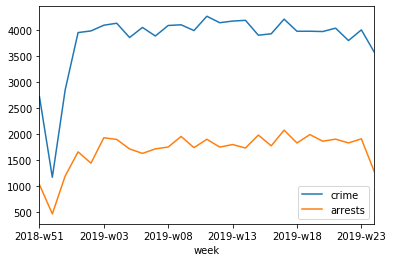

In [8]:
table_week.plot();

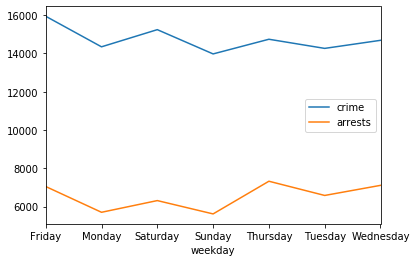

In [11]:
# creating a table of incidents per day
table_weekday = pd.DataFrame()
table_weekday['crime'] = cri.groupby('weekday').size()
table_weekday['arrests'] = arr.groupby('weekday').size()
table_weekday.plot();

In [153]:
cri['Weapon Description'].value_counts() /cri['Weapon Description'].value_counts().sum()

STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    0.586618
UNKNOWN WEAPON/OTHER WEAPON                       0.090193
VERBAL THREAT                                     0.081398
HAND GUN                                          0.050479
KNIFE WITH BLADE 6INCHES OR LESS                  0.019533
OTHER KNIFE                                       0.017186
SEMI-AUTOMATIC PISTOL                             0.014488
UNKNOWN FIREARM                                   0.012195
VEHICLE                                           0.010927
ROCK/THROWN OBJECT                                0.008418
STICK                                             0.007338
CLUB/BAT                                          0.006934
BOTTLE                                            0.006745
FOLDING KNIFE                                     0.006502
PIPE/METAL PIPE                                   0.006394
MACE/PEPPER SPRAY                                 0.006340
KITCHEN KNIFE                                     0.0058

In [36]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date', 'week',
       'weekday'],
      dtype='object')

In [ ]:
cri['Status Description'].value_counts() /cri['Status Description'].value_counts().sum()

In [55]:
cri[['Date Reported','Date Occurred', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4']].tail()

,Date Reported,Date Occurred,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4
1993254,6242019-01-01T00:00:00,2019-06-21T00:00:00,X,404.0,DEPARTMENT STORE,NaN,NaN,IC,Invest Cont,442.0,NaN,NaN,NaN
1993255,1152019-01-01T00:00:00,2019-01-15T00:00:00,H,101.0,STREET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,910.0,NaN,NaN,NaN
1993256,2022019-01-01T00:00:00,2019-02-01T00:00:00,X,101.0,STREET,NaN,NaN,IC,Invest Cont,946.0,998.0,NaN,NaN
1993257,4262019-01-01T00:00:00,2019-02-05T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN
1993258,4262019-01-01T00:00:00,2019-01-07T00:00:00,NaN,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN


In [18]:
cri['Crime Code Description'].value_counts().head() / float(cri['Crime Code Description'].value_counts().sum())


AttributeError: 'int' object has no attribute 'head'

In [16]:
cri['Crime Code Description'].value_counts().head(10)

BATTERY - SIMPLE ASSAULT                                   9184
BURGLARY FROM VEHICLE                                      8392
VEHICLE - STOLEN                                           7487
THEFT PLAIN - PETTY ($950 & UNDER)                         7289
BURGLARY                                                   6232
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    6226
INTIMATE PARTNER - SIMPLE ASSAULT                          5735
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             5144
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            4747
ROBBERY                                                    4129
Name: Crime Code Description, dtype: int64

In [22]:
arr['Charge Description'].value_counts().head(10)

DRUNK DRIVING ALCOHOL/DRUGS                 95410
DRINKING IN PUBLIC                          92965
CORPORAL INJURY ON SPOUSE/COHABITANT/ETC    44812
POSSESSION CONTROLLED SUBSTANCE             43697
FTA AFTER WRITTEN PROMISE                   31177
POSSESSION NARCOTIC CONTROLLED SUBSTANCE    29352
PROSTITUTION                                26169
OPEN ALCOHOLIC BEV IN PUBLIC PARK/PLACE     25668
SIT/LIE/SLEEP SIDEWALK OR STREET            25573
LOS ANGELES MUNICIPAL CODE                  24367
Name: Charge Description, dtype: int64

In [29]:
arr.columns

Index(['Report ID', 'Arrest Date', 'Time', 'Area ID', 'Area Name',
       'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [31]:
arr[['Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description','LA Specific Plans']].head()

,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,LA Specific Plans
0,M,W,24.0,Miscellaneous Other Violations,M,594(A)PC,VANDALISM,10.0
1,M,O,NaN,NaN,O,300(B)WIC,NaN,NaN
2,F,O,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,17.0
3,F,W,22.0,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,NaN
4,M,W,8.0,Other Assaults,F,69PC,OBSTRUCT/RESIST EXECUTIVE OFFICER,10.0


In [121]:
cri.columns

Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')

In [9]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [26]:
arr['Arrest Type Code'].value_counts() / arr.shape[0]

M    0.530840
F    0.367782
I    0.072178
O    0.023885
D    0.005315
Name: Arrest Type Code, dtype: float64

In [23]:
arr[arr['Charge Description'] =='ROBBERY']['Charge Group Description']

117      Robbery
242      Robbery
259      Robbery
332      Robbery
428      Robbery
509      Robbery
540      Robbery
559      Robbery
573      Robbery
619      Robbery
658      Robbery
670      Robbery
707      Robbery
783      Robbery
838      Robbery
852      Robbery
890      Robbery
900      Robbery
1023     Robbery
1054     Robbery
1094     Robbery
1182     Robbery
1251     Robbery
1287     Robbery
1336     Robbery
1371     Robbery
1399     Robbery
1426     Robbery
1525     Robbery
1541     Robbery
          ...   
44559    Robbery
44569    Robbery
44590    Robbery
44607    Robbery
44613    Robbery
44620    Robbery
44640    Robbery
44697    Robbery
44764    Robbery
44809    Robbery
44833    Robbery
44864    Robbery
44932    Robbery
44957    Robbery
45005    Robbery
45027    Robbery
45028    Robbery
45064    Robbery
45069    Robbery
45090    Robbery
45172    Robbery
45291    Robbery
45439    Robbery
45447    Robbery
45497    Robbery
45513    Robbery
45549    Robbery
45624    Robbe

In [10]:
arr[arr['Charge Group Description']=='Driving Under Influence']['Charge Description'].value_counts()

DRUNK DRIVING ALCOHOL/DRUGS                  2991
DUI OF ANY DRUG                               450
DUI ALCOHOL CAUSING INJURY                    301
DRUNK DRIVING .10 OR ABOVE                    264
DUI OF ALCOHOL & DRUG                          57
DUI ALCOHOL/DRUGS ON BICYCLE                   49
DUI OF A DRUG CAUSING INJURY                   23
DUI ALCOHOL/DRUG W/PRIORS                      21
DUI W/PRIOR SPEC CONVICTIONS                   10
OPERATE MOTOR SCOOTR WHILE UNDER INFLUENC       9
DUI .08 ALCOHOL CAUSING INJURY                  7
FELONY FOR FOURTH DUI                           5
DRUNK DRIVING ADDICT DRIVE VEHICLE              4
DRIVING COMMERCIAL VEH W/.04 BLOOD/ALCOHL       3
DUI OF COMB DRUG & ALCOHOL INFLUENCE            3
DUI ALCOHOL/0.08 W/PRS                          2
DUI OF ALCOHOL & DRUG CAUSING INJURY            1
< AGE 21 DRIVING VEH W/BLOOD-ALCOHOL .01+       1
MINOR DRIVE W/BLOOD ALCOHOL OF 0.05%+           1
Name: Charge Description, dtype: int64

In [30]:
arr['Charge Group Description'].value_counts()

Miscellaneous Other Violations    7447
Narcotic Drug Laws                4909
Aggravated Assault                4454
Driving Under Influence           4202
Other Assaults                    3713
Larceny                           2495
Moving Traffic Violations         1623
Liquor Laws                       1586
Weapon (carry/poss)               1559
Vehicle Theft                     1438
Robbery                           1354
Prostitution/Allied               1348
Drunkeness                        1030
Burglary                           919
Sex (except rape/prst)             502
Disorderly Conduct                 466
Against Family/Child               465
Fraud/Embezzlement                 388
Receive Stolen Property            194
Forgery/Counterfeit                163
Rape                               153
Non-Criminal Detention             122
Homicide                           116
Gambling                           101
Disturbing the Peace                45
Pre-Delinquency          

In [17]:
arr['br'] = arr['Charge Description'].str.contains('|'.join(['BRANDISH']))

In [18]:
arr[arr['br']==1][['Charge Description', 'Charge Group Description']]

,Charge Description,Charge Group Description
41364,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault
41399,BRANDISH F/ARM REPLICA AT OCCUPANT OF VEH,Aggravated Assault


In [39]:
arr.columns

Index(['Unnamed: 0', 'Report ID', 'Arrest Date', 'Time', 'Area ID',
       'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code',
       'Charge Group Code', 'Charge Group Description', 'Arrest Type Code',
       'Charge', 'Charge Description', 'Address', 'Cross Street', 'Location',
       'Zip Codes', 'Census Tracts', 'Precinct Boundaries',
       'LA Specific Plans', 'Council Districts',
       'Neighborhood Councils (Certified)'],
      dtype='object')

In [8]:
cri.columns


Index(['Unnamed: 0', 'DR Number', 'Date Reported', 'Date Occurred',
       'Time Occurred', 'Area ID', 'Area Name', 'Reporting District',
       'Crime Code', 'Crime Code Description', 'MO Codes', 'Victim Age',
       'Victim Sex', 'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location ', 'date'],
      dtype='object')